In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import NearestNeighbors

In [2]:
def load_data():
    train = pd.read_csv('train.dat', sep=' ', encoding='latin1')
    test = pd.read_csv('test.dat', sep=' ', encoding='latin1')
    movie_genres = pd.read_csv('movie_genres.dat', sep='\t', encoding='latin1')
    movie_directors = pd.read_csv('movie_directors.dat', sep='\t', encoding='latin1')
    movie_actors = pd.read_csv('movie_actors.dat', sep='\t', encoding='latin1')


    movie_tags = pd.read_csv('movie_tags.dat', sep='\t', encoding='latin1')
    return train, test, movie_genres, movie_directors, movie_actors, movie_tags



In [3]:
train, test, movie_genres, movie_directors, movie_actors, movie_tags = load_data()

In [4]:
train

,userID,movieID,rating
0,75,3,1.0
1,75,32,4.5
2,75,110,4.0
3,75,163,4.0
4,75,165,4.5
...,...,...,...
641694,71534,42900,4.0
641695,71534,44555,4.0
641696,71534,46578,4.0
641697,71534,61075,5.0


In [5]:
test

,userID,movieID
0,75,653
1,75,1527
2,75,3258
3,75,7007
4,78,82
...,...,...
71294,71534,2208
71295,71534,2997
71296,71534,4306
71297,71534,7132


In [6]:
movie_genres

,movieID,genre
0,1,Adventure
1,1,Animation
2,1,Children
3,1,Comedy
4,1,Fantasy
...,...,...
20804,65126,Comedy
20805,65126,Drama
20806,65130,Drama
20807,65130,Romance


In [7]:
movie_directors

,movieID,directorID,directorName
0,1,john_lasseter,John Lasseter
1,2,joe_johnston,Joe Johnston
2,3,donald_petrie,Donald Petrie
3,4,forest_whitaker,Forest Whitaker
4,5,charles_shyer,Charles Shyer
...,...,...,...
10150,65088,adam_shankman,Adam Shankman
10151,65091,ws_van_dyke,W.S. Van Dyke
10152,65126,clark_gregg,Clark Gregg
10153,65130,sam_mendes,Sam Mendes


In [8]:
movie_actors

,movieID,actor_id,actor_name,ranking
1,1,annie_potts,Annie Potts,10.0
2,1,bill_farmer,Bill Farmer,20.0
3,1,don_rickles,Don Rickles,3.0
4,1,erik_von_detten,Erik von Detten,13.0
5,1,greg-berg,Greg Berg,17.0
...,...,...,...,...
231738,65133,rik_mayall,Rik Mayall,6.0
231739,65133,rowan_atkinson,Rowan Atkinson,7.0
231740,65133,stephen_fry,Stephen Fry,8.0
231741,65133,tim_mcinnerny,Tim McInnerny,9.0


In [9]:
movie_tags

,movieID,tagID,tagWeight
0,1,7,1
1,1,13,3
2,1,25,3
3,1,55,3
4,1,60,1
...,...,...,...
51790,65037,792,1
51791,65037,2214,1
51792,65126,5281,1
51793,65126,13168,1


In [10]:
print(movie_genres.columns)
print(movie_directors.columns)
print(movie_actors.columns)
print(movie_tags.columns)

Index(['movieID', 'genre'], dtype='object')
Index(['movieID', 'directorID', 'directorName'], dtype='object')
Index(['movieID', 'actor_id', 'actor_name', 'ranking'], dtype='object')
Index(['movieID', 'tagID', 'tagWeight'], dtype='object')


In [11]:
movie_actors['actor_name'] = movie_actors['actor_name'].fillna('').astype(str)
movie_directors['directorName'] = movie_directors['directorName'].fillna('').astype(str)
movie_genres['genre'] = movie_genres['genre'].fillna('').astype(str)
movie_tags['tagId'] = movie_tags['tagID'].fillna('').astype(str)


In [4]:
def build_movie_metadata(movie_genres, movie_directors, movie_actors, movie_tags):
    genres = movie_genres.groupby('movieID')['genre'].apply(lambda x: ' '.join(map(str, x)))
    directors = movie_directors.groupby('movieID')['directorName'].apply(lambda x: ' '.join(map(str, x)))
    actors = movie_actors.groupby('movieID')['actorName'].apply(lambda x: ','.join(map(str, x)))
    tags = movie_tags.groupby('movieID')['tagID'].apply(lambda x: ' '.join(map(str, x)))

    metadata = pd.DataFrame({
        'movieID': genres.index,
        'genres': genres.values,
        'directors': directors.reindex(genres.index, fill_value='').values,
        'actors': actors.reindex(genres.index, fill_value='').values,
        'tags': tags.reindex(genres.index, fill_value='').values
    }).reset_index(drop=True)

    return metadata


In [5]:
movie_metadata = build_movie_metadata(movie_genres, movie_directors, movie_actors, movie_tags)

In [6]:
movie_metadata

,movieID,genres,directors,actors,tags
0,1,Adventure Animation Children Comedy Fantasy,John Lasseter,"Annie Potts,Bill Farmer,Don Rickles,Erik von D...",7 13 25 55 60 146 326 351 362 382 459 465 501 ...
1,2,Adventure Children Fantasy,Joe Johnston,"Peter Bryant,Adam Hann-Byrd,Bebe Neuwirth,Bonn...",13 117 146 413 438 488 742 1224 1843 1944 2057...
2,3,Comedy Romance,Donald Petrie,"Ann-Margret,Buck Henry,Buffy Sedlachek,Burgess...",380 2724 3196 3242 7444 13668
3,4,Comedy Drama Romance,Forest Whitaker,"Leon,Angela Bassett,Brandon Hammond,Dennis Hay...",
4,5,Comedy,Charles Shyer,"Ann Walker,Annie Meyers-Shyer,April Ortiz,B.D....",125 747 752 1646 2724 4294 4946 4953
...,...,...,...,...,...
10192,65088,Adventure Children Comedy,Adam Shankman,"Teresa Palmer,Abigail Leone Droeger,Adam Sandl...",
10193,65091,Crime Drama Romance,W.S. Van Dyke,"Al Thompson,Alex Melesh,Bert Russell,Bert Spro...",
10194,65126,Comedy Drama,Clark Gregg,"Anjelica Huston,Bijou Phillips,Brad William He...",5281 13168
10195,65130,Drama Romance,Sam Mendes,"Kathryn Hahn,David Harbour,Dylan Baker,Jay O S...",2924


In [7]:
movie_metadata['actors']

0        Annie Potts,Bill Farmer,Don Rickles,Erik von D...
1        Peter Bryant,Adam Hann-Byrd,Bebe Neuwirth,Bonn...
2        Ann-Margret,Buck Henry,Buffy Sedlachek,Burgess...
3        Leon,Angela Bassett,Brandon Hammond,Dennis Hay...
4        Ann Walker,Annie Meyers-Shyer,April Ortiz,B.D....
                               ...                        
10192    Teresa Palmer,Abigail Leone Droeger,Adam Sandl...
10193    Al Thompson,Alex Melesh,Bert Russell,Bert Spro...
10194    Anjelica Huston,Bijou Phillips,Brad William He...
10195    Kathryn Hahn,David Harbour,Dylan Baker,Jay O S...
10196    Colin Firth,Hugh Laurie,Kate Moss,Miranda Rich...
Name: actors, Length: 10197, dtype: object

Extracted genres (first 10): ['John Lasseter', 'Joe Johnston', 'Donald Petrie', 'Forest Whitaker', 'Charles Shyer', 'Michael Mann', 'Billy Wilder', 'Peter Hewitt', 'Peter Hyams', 'Martin Campbell']


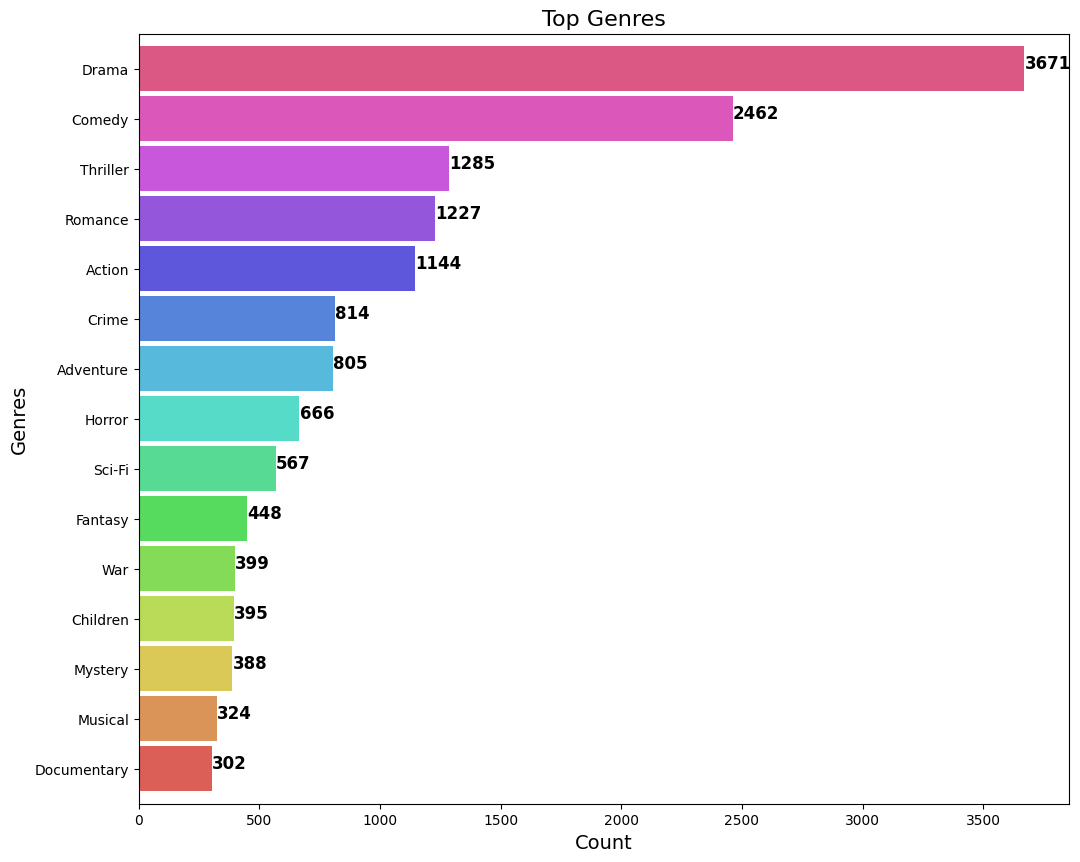

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

list_genre = []
for i in movie_metadata['genres']:
    if isinstance(i, str) and i.strip():  # Ensure non-empty strings
        list_genre.extend(i.split())  # Split genres by spaces

# Debug: Check extracted genres
print("Extracted genres (first 10):", list1[:10])

# Generate the plot
plt.subplots(figsize=(12, 10))
ax = pd.Series(list_genre).value_counts()[:15].sort_values(ascending=True).plot.barh(
    width=0.9, color=sns.color_palette('hls', 15)
)

# Annotate bar counts
for i, v in enumerate(pd.Series(list_genre).value_counts()[:15].sort_values(ascending=True).values):
    ax.text(v + 1, i, str(v), fontsize=12, color='black', weight='bold')  # Adjust position as needed

plt.title('Top Genres', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Genres', fontsize=14)
plt.show()


In [12]:
# Create a dictionary for fast lookup of weights
weights_dict = dict(zip(movie_tags['tagID'], movie_tags['tagWeight']))


In [16]:
def calculate_impactfactor(tags):
    if pd.isna(tags):  # Handle missing tags
        return 0
    tag_ids = map(float, tags.split())  # Split the tag IDs and convert to integers
    return sum(1 / weights_dict[tag_id] for tag_id in tag_ids if tag_id in weights_dict)


In [17]:
movie_metadata['impactfactor'] = movie_metadata['tags'].apply(calculate_impactfactor)

In [19]:
movie_metadata = movie_metadata[movie_metadata['impactfactor']!=0]

In [20]:
movie_metadata

,movieID,genres,directors,actors,tags,impactfactor
0,1,Adventure Animation Children Comedy Fantasy,John Lasseter,"Annie Potts,Bill Farmer,Don Rickles,Erik von D...",7 13 25 55 60 146 326 351 362 382 459 465 501 ...,37.944444
1,2,Adventure Children Fantasy,Joe Johnston,"Peter Bryant,Adam Hann-Byrd,Bebe Neuwirth,Bonn...",13 117 146 413 438 488 742 1224 1843 1944 2057...,15.750000
2,3,Comedy Romance,Donald Petrie,"Ann-Margret,Buck Henry,Buffy Sedlachek,Burgess...",380 2724 3196 3242 7444 13668,5.500000
4,5,Comedy,Charles Shyer,"Ann Walker,Annie Meyers-Shyer,April Ortiz,B.D....",125 747 752 1646 2724 4294 4946 4953,6.833333
5,6,Action Crime Thriller,Michael Mann,"Al Pacino,Amy Brenneman,Ashley Judd,Begonia Pl...",351 528 587 638 662 675 1149 1218 1277 1974 23...,21.166667
...,...,...,...,...,...,...
10186,64993,Animation Drama Romance,Makoto Shinkai,"Ayaka Onoue,Kenji Mizuhashi,Satomi Hanamura,Sa...",473 687 712 740,3.500000
10189,65006,Mystery Thriller,Charles T. Kanganis,"Angus Macfadyen,C. Earnst Harth,C. Ernst Harth...",595,1.000000
10191,65037,Drama,Nic Balthazar,"Greg Timmermans,Marijke Pinoy,Laura Verlinden,...",160 784 792 2214,4.000000
10194,65126,Comedy Drama,Clark Gregg,"Anjelica Huston,Bijou Phillips,Brad William He...",5281 13168,2.000000


Extracted actors (first 10): ['John Lasseter', 'Joe Johnston', 'Donald Petrie', 'Forest Whitaker', 'Charles Shyer', 'Michael Mann', 'Billy Wilder', 'Peter Hewitt', 'Peter Hyams', 'Martin Campbell']


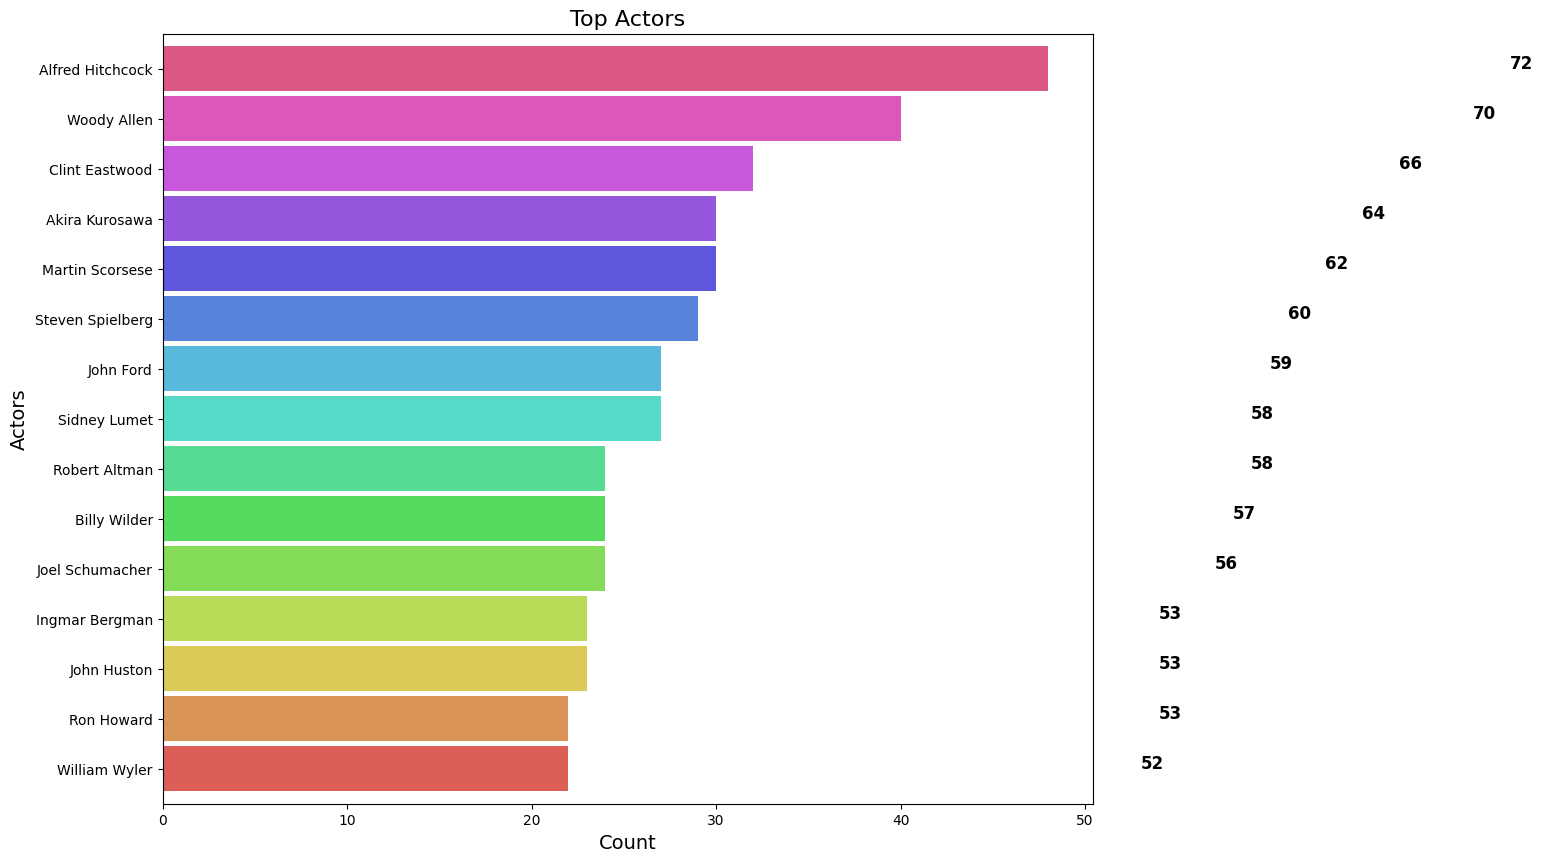

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

list_actors = []
for i in movie_actors['actorName']:
    if isinstance(i, str) and i.strip():  # Ensure non-empty strings
        list_actors.extend(i.split(','))  # Split genres by spaces

# Debug: Check extracted genres
print("Extracted actors (first 10):", list1[:10])

# Generate the plot
plt.subplots(figsize=(12, 10))
ax = pd.Series(list1).value_counts()[:15].sort_values(ascending=True).plot.barh(
    width=0.9, color=sns.color_palette('hls', 15)
)

# Annotate bar counts
for i, v in enumerate(pd.Series(list_actors).value_counts()[:15].sort_values(ascending=True).values):
    ax.text(v + 1, i, str(v), fontsize=12, color='black', weight='bold')  # Adjust position as needed

plt.title('Top Actors', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Actors', fontsize=14)
plt.show()


Extracted actors (first 10): ['John Lasseter', 'Joe Johnston', 'Donald Petrie', 'Forest Whitaker', 'Charles Shyer', 'Michael Mann', 'Billy Wilder', 'Peter Hewitt', 'Peter Hyams', 'Martin Campbell']


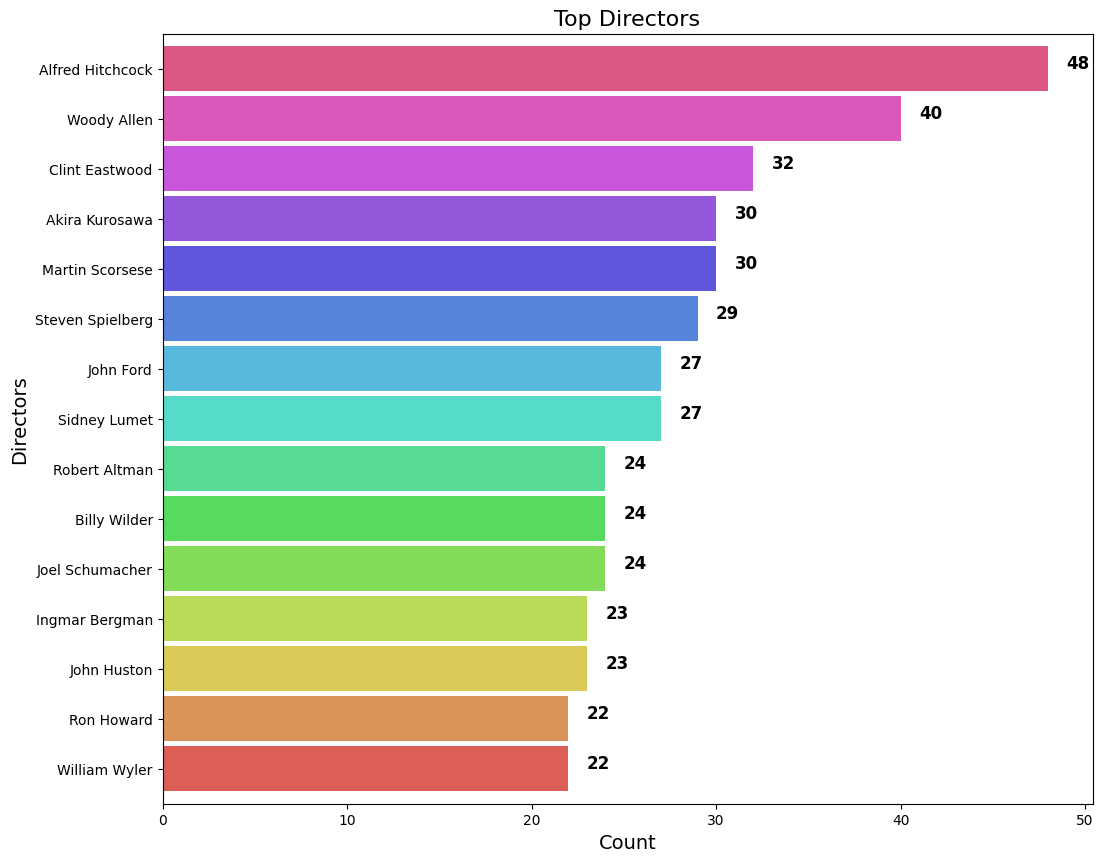

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

list_dir = []
for i in movie_directors['directorName']:
    if isinstance(i, str) and i.strip():  # Ensure non-empty strings
        list_dir.append(i.strip())  # Split genres by spaces

# Debug: Check extracted genres
print("Extracted actors (first 10):", list1[:10])

# Generate the plot
plt.subplots(figsize=(12, 10))
ax = pd.Series(list1).value_counts()[:15].sort_values(ascending=True).plot.barh(
    width=0.9, color=sns.color_palette('hls', 15)
)

# Annotate bar counts
for i, v in enumerate(pd.Series(list_dir).value_counts()[:15].sort_values(ascending=True).values):
    ax.text(v + 1, i, str(v), fontsize=12, color='black', weight='bold')  # Adjust position as needed

plt.title('Top Directors', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Directors', fontsize=14)
plt.show()


In [49]:
# 2. Collaborative Filtering with Parameter Tuning
def collaborative_filtering(train):
    user_item_matrix = train.pivot(index='userID', columns='movieID', values='rating').fillna(0)
    best_svd = None
    best_rmse = float('inf')
    
    # Hyperparameter tuning for SVD
    n_components_range = [1000,1500,2000]
    for n_components in n_components_range:
        svd = TruncatedSVD(n_components=n_components, random_state=42)
        user_features = svd.fit_transform(user_item_matrix)
        movie_features = svd.components_
        
        # Compute RMSE using 5-fold cross-validation
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        fold_rmse = []
        for train_idx, val_idx in kf.split(user_item_matrix):
            train_matrix = user_item_matrix.iloc[train_idx]
            val_matrix = user_item_matrix.iloc[val_idx]
            pred_matrix = np.dot(user_features, movie_features)
            true_values = val_matrix.values.flatten()
            pred_values = pred_matrix[val_idx].flatten()
            fold_rmse.append(np.sqrt(mean_squared_error(true_values, pred_values)))
        
        mean_rmse = np.mean(fold_rmse)
        if mean_rmse < best_rmse:
            best_rmse = mean_rmse
            best_svd = svd

    return best_svd, best_rmse

In [50]:
best_svd = collaborative_filtering(train)

In [51]:
print(best_svd)

(TruncatedSVD(n_components=2000, random_state=42), 0.011753133627595322)


In [62]:
def generate_predictions_for_test(test, best_svd, train):
    best_svd = best_svd[0]
    # Recreate user-item matrix from the train data
    user_item_matrix = train.pivot(index='userID', columns='movieID', values='rating').fillna(0)

    # Get user and movie features using the best SVD
    user_features = best_svd.fit_transform(user_item_matrix)
    movie_features = best_svd.components_

    # Generate predictions for the test set
    predictions = []

    for _, row in test.iterrows():
        user_id = row['userID']
        movie_id = row['movieID']

        if user_id in user_item_matrix.index and movie_id in user_item_matrix.columns:
            # Case 1: Both user and movie are known
            user_vector = user_features[user_item_matrix.index.get_loc(user_id)]
            movie_vector = movie_features[:, user_item_matrix.columns.get_loc(movie_id)]
            predicted_rating = np.dot(user_vector, movie_vector)
        elif user_id in user_item_matrix.index:
            # Case 2: User is known, but the movie is new
            user_vector = user_features[user_item_matrix.index.get_loc(user_id)]
            predicted_rating = np.mean(np.dot(user_vector, movie_features))  # Average across all movies
        elif movie_id in user_item_matrix.columns:
            # Case 3: Movie is known, but the user is new
            movie_vector = movie_features[:, user_item_matrix.columns.get_loc(movie_id)]
            predicted_rating = np.mean(np.dot(user_features, movie_vector))  # Average across all users
        else:
            # Case 4: Both user and movie are new
            predicted_rating = user_item_matrix.values.mean()
        
        predictions.append(predicted_rating)

    # Save predictions to .dat file
    with open("example_entry.dat", "w") as f:
        for pred in predictions:
            f.write(f"{pred:.2f}\n")

    print(f"Predictions saved to 'test_predictions.dat'")
    return predictions

In [63]:
predictions = generate_predictions_for_test(test, best_svd, train)

Predictions saved to 'test_predictions.dat'


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import make_scorer, pairwise_distances

def content_based_filtering_with_cv(movie_metadata):
    
    
    # Define parameter grid for k and distance metrics
    param_grid = {
        'n_neighbors': [3, 5, 7, 10],  # Different values of k
        'metric': ['cosine', 'euclidean', 'manhattan'],  # Different distance metrics
    }

    # Initialize Nearest Neighbors model
    nn_model = NearestNeighbors()

    # Setup GridSearchCV with 5-fold cross-validation
    grid_search = GridSearchCV(estimator=nn_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    
    # Fit the grid search
    grid_search.fit(movie_metadata)
    
    # Get the best parameters from grid search
    best_params = grid_search.best_params_
    print(f"Best parameters: {best_params}")

    # Best estimator can be accessed as follows:
    best_nn_model = grid_search.best_estimator_

    return best_nn_model, grid_search
